# Lecture 10: More on Gibbs sampling
AM207: Verena Kaynig-Fittkau,and Pavlos Protopapas, Harvard University


In [8]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pymc as pm
sns.set_style('white')
sns.set_context('paper')

# Example Gibbs Sampling

Note: This example is stolen from last years lab section.

<center> $f(x,y) = x^2 {\rm exp}[-xy^2 - y^2 + 2y - 4x]$ </center>

Here's what the distribution really looks like.

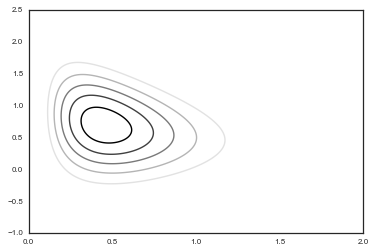

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

func = lambda x,y: x**2*np.exp( -x*y**2 - y**2 + 2*y - 4*x )

foo=400
x = np.linspace(0,2,foo)
y = np.linspace(-1,2.5,foo)
xx,yy = np.meshgrid(x,y)
zz = np.zeros((foo,foo))
for i in np.arange(0,foo):
    for j in np.arange(0,foo):
        zz[i,j]=func(xx[i,j],yy[i,j])
        
plt.contour(xx,yy,zz)

Okay, so it's a pretty distribution, but on first glance the functional form looks terrible and difficult to deal with. But remember from class, a particular power of the Gibbs sampler is that you can directly sample from the conditionals (alternately of course). All we need to do is a little math to construct the functional form of the conditionals and put them in terms of something that we know how to sample from quickly. In the case of our $f(x,y)$ we have:

<center>$f(x|y) = x^2 {\rm exp}[-x (y^2 +4)]{\rm exp}[- y^2 + 2y]$</center> <br><br>
<center>$f(x|y) = x^2 {\rm exp}[-x (y^2 +4)] g(y)$</center> <br><br>
<center>$f(x|y) = g(y){\rm Gamma}(3,y^2+4)$</center>

and...

<center>$f(y|x) = x^2 {\rm exp}[-y^2(1+x) + 2y]{\rm exp}[-4x]$</center> <br><br>
<center>$f(y|x) = x^2 {\rm exp}[-y^2(1+x)] g(x)$</center> <br><br>
<center>$f(y|x) = g(x)N(\frac{1}{1+x},\frac{1}{\sqrt{(2(1+x))}})$</center>

So we now invoke our Gibbs sampler to select directly from the functional forms of the conditionals because we know how to sample from a Normal distribution and we know how to sample from a Gamma distribution. In the following code we sample a number of size N=10,000 samples, using thinning to reduce the autocorrelation of samples.  


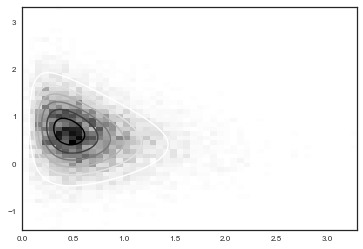

In [10]:
import random,math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def gibbs(N=10000, start = [0,0]):
    x=start[0]
    y=start[1]
    samples=np.zeros((2,N+1))
    samples[0,0]=x
    samples[1,0]=y
    
    for i in range(1,N,2):
        x=random.gammavariate(3.0, 1.0/(y**2 + 4))
        samples[0,i]=x
        samples[1,i]=y
        
        y=random.gauss(1.0/(x+1), 1.0/np.sqrt(2*(x+1)) )
        samples[0,i+1]=x
        samples[1,i+1]=y
        
    return samples[:,:N]

out=gibbs()

plt.hist2d(out[0,:],out[1,:], normed=True, bins=50)
plt.contour(xx,yy,zz)
plt.show()

Let's look at the single steps the Gibbs sampler is taking:

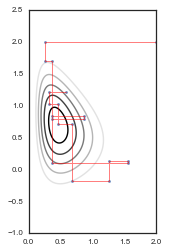

In [11]:
out=gibbs(start = [2,2])
nr_t = 20
plt.contour(xx,yy,zz)
plt.plot(out[0,:nr_t],out[1,:nr_t], '.',alpha=0.8)
plt.plot(out[0,:nr_t],out[1,:nr_t], c='r', alpha=0.5, lw=1)
ax=plt.gca()
ax.set_aspect('equal')

Looking at the autocorrelation of our samples we are in pretty good shape and probably don't have to worry much about thinning here. Note that this is not always the case for Gibbs sampling. The other notebook has an example where we need to have a lot of thinning to account for the autocorrelation of the samples. It all depends on the shape of our target distribution. 

Plotting x


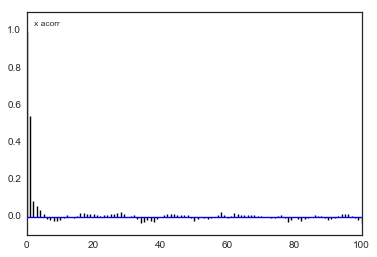

In [12]:
x = out[0,:]
pm.Matplot.autocorrelation(x, "x")

Plotting y


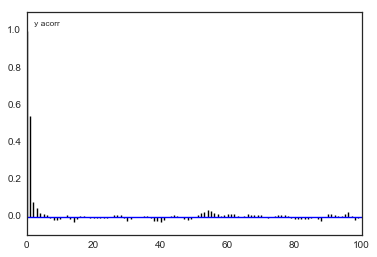

In [13]:
y = out[1,:]
pm.Matplot.autocorrelation(y, "y")

## Example: Rats tumors (from [Gelman](http://www.stat.columbia.edu/~gelman/book/), chapter 5)


The below data is from tumors in female rats of type "F344" that recieve a particular drug, in 70 different experiments. 

The first column is the number that get the tumor; the second is the total number or rats tested

#### First we get some data:

In [14]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

In [15]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
#print tumory, tumorn            

In [16]:
# this only takes every second data point
#tumory = tumory[::2]
#tumorn = tumorn[::2]
#print tumory.shape

Now, a 71st experiment is done and we are told that 4 out of 14 rats develop tumors. Our problem is  to estimate the risk of tumor $\theta_{71}$ in these rats. 

Since we have historical data from 70 previous experiments to rely on, we can use that data to help us make this estimate, in a Bayesian manner, by calculating the posterior for $\theta_{71}$. 

In the $j$-th historical experiment, let the number of rats with tumors be $y_j$ and the total number of rats be $n_j$.
Since the rats either have or dont have the tumor, it makes sense to use a Binomial Model for **each** experiment, assumes a sample size $n_j$ and a probability $\theta_j$ that a rat has a tumor. For any one of the experiments

$$p(y_i|\theta_i; n_i) =  Binom(n_i, y_i, \theta_i) $$

and for all the data we have, using $Y=[y_1,\ldots, y_{70}]$ and $\Theta = [\theta_1, \ldots, \theta_{70}]$ and I use the notation
$\{n_i\} =[n_1, \ldots, n_{70}]$

$$ p(Y|\Theta; \{n_i\}) =  \prod_{i=1}^{70}Binom(n_i, y_i, \theta_i) $$


We now need to choose a prior $p(\Theta)$. Our first thought might be to use a Beta (conjugate prior to Binomial) for each $\theta_i$, i.e.

$$ \theta_i \sim Beta(\alpha_i, \beta_i).$$

$$p(\Theta| \{\alpha_i\}, \{\beta_i\}) = \prod_{i=1}^{70} Beta(\theta_i, \alpha_{i}, \beta_{i}),$$

where $\alpha_i$ and $\beta_i$ are what we called **hyperparameters**. Again I use the notation $\{\alpha_i\}=[\alpha_1, \ldots, \alpha_{70} ]$ and similarly for $\{beta\}$.

However, we would then come up with a very overfit model with 210 parameters and not much data. Besides, there are likely outliers in some experiments, small sample sizes, etc (this is called unpooled).

The other extreme is to assume that there is only one $\theta$ in the problem, and set an prior on it, making this a three parameter problem. This ignores any variation amongst the sampling units other than sampling variance, and such a model might thus be underfit, unable to capture the variations in the samples (complete pooling).

Let us compromise and assume that the $\theta_i$s are drawn from a "population distribution" given by a conjugate Beta prior $Beta(\alpha, \beta)$ with parameters $\alpha$ and $\beta$ to describe this data (partial pooling).

$$ \theta_i \sim Beta(\alpha, \beta).$$

$$p(\Theta | \alpha, \beta) = \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta).$$

This structure is shown in the diagram below.

<img src="./Lecture10_data/hier.png" width="320" height="240"/>

Such a model is called a **hierarchical** model, with observable outcomes modeled conditionally on certain parameters($\theta$s) which themselves are given a probabilistic specification in terms of further parameters ($\alpha$ and $\beta$), known as **hyperparameters**.

Modeling in this way has two advantages: (a) as we shall see, it helps us develop a computational strategy to solve the problem, and (b) it allows estimates of the probabilities of any one of the units (here, one of the experiments) to borrow strength from all the data as a whole through the estimation of the hyperparameters. In other words, if some of the experiments had lower sample sizes or other outlier like behavior, the procedure helps "regularize" this.

### Full Bayesian Treatment

To do that we need to specify a **hyper-priors** $p(\alpha, \beta)$ on these hyperparameters ($\alpha, \beta$). The idea of the hyper-prior is the same as that of a prior; except that the hyperpriors are priors on prior parameters.  We typically use uninformative hyperpriors: indeed this is one of the key strategies of hierarchical modelling: un-informative priors are pushed down the prior hierarchy.

We then write out a joint posterior distribution for the $\theta$s, $\alpha$ and $\beta$.

$$p( \theta_i, \alpha, \beta | y_i, n_i) \propto p(\alpha, \beta) \, p(\theta_i | \alpha, \beta) \, p(y_i | \theta_i, n_i,\alpha, \beta)$$

or for the whole dataset:

$$ p( \Theta, \alpha, \beta | Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Note that this is a high dimensional problem: there are 72 parameters (70 $\theta$s and $\alpha , \beta$).

The conditional posterior distribution for each of the $\theta_i$, given everything else is a Beta distribution itself (remember Beta is conjugate prior to Bionomial).

$p(\theta_i | y_i, n_i, \alpha, \beta) = Beta(\alpha + y_i, \beta + n_i - y_i)$ 


For each of $\alpha$ and $\beta$, given everything else, the posterior distributions can be shown to be:

$$p(\alpha | Y, \Theta ,\beta ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)}\right)^N \prod_{i=1}^{N} \theta_i^{\alpha}$$

$$P(\beta | Y, \Theta ,\alpha ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\beta)}\right)^N \prod_{i=1}^{N} (1 - \theta_i)^{\beta}$$

Note: The conditional posteriors do depend on $Y$ and $\{n\}$ via the $\theta$'s. 

### Choosing a hyperprior

The 'prior' mean $\mu$ of the beta population distribution for $\{\theta_i\}$ is given by $\frac{\alpha}{\alpha + \beta}$, and the variance is given by $\frac{\mu (1-\mu)}{\alpha +\beta +1}$. It makes sense to independly choose uninformative, uniform priors on the mean and the standard deviation in units of the mean. 

We thus choose to set up a uniform prior on 

$$\left(\frac{\alpha}{\alpha + \beta}, (\alpha + \beta)^{-1/2}\right),$$

(the second is approximate) which when multiplied by the Jacobian of the transformation from $(\alpha, \beta)$ yields  a hyperprior $p(\alpha, \beta) \sim (\alpha + \beta)^{-5/2}$.  

This is not the only scheme via which an uninformative hyperprior distribution which will be dominated by the likelihood can be set, and it is worth exploring other options, such as other powers of $(\alpha + \beta)$.



### Sampling

We construct a combined Gibbs sampler and MH sampler using the above conditionals: the draws for the $\theta_i$ is simple because of conjugacy. But for $\alpha$ and $\beta$, we implement a Metropolis-Hastings sampler, use a normal proposal with mean the current values of $\alpha$ and $\beta$  and standard deviations 0.25 and 3 respectively, remembering to reject negative values from the proposal. Each step of the 70 gibbs samplers are alternated with each step of the MH sampler for $\alpha$ and $\beta$. 



In [17]:
# number of thetas
numthetas=tumorn.shape[0]
print numthetas

70


We set up python functions for each draw

In [18]:
from scipy.special import gammaln

# prior for the hyperparameters
log_prior = lambda a,b: -2.5*np.log(a + b)

# sampling from conditional posterior for the theta
draw_thetas = lambda a,b: beta.rvs(a+tumory,b+tumorn-tumory, size=numthetas)

# conditional posterior (pdf) for alpha
def log_cond_alpha(a,b, thetas):
    return numthetas*(gammaln(a+b) - gammaln(a)) + a*np.sum(np.log(thetas)) + log_prior(a,b)
   
# conditional posterior (pdf) for beta
def log_cond_beta(a,b, thetas):
    return numthetas*(gammaln(a+b) - gammaln(b)) + b*np.sum(np.log(1.0 - thetas)) + log_prior(a,b)
  
# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha(a,b,thetas,proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)  # proposed a new alpha
    num = log_cond_alpha(astar,b, thetas) 
    den = log_cond_alpha(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den) and (astar >0):#little built in rejection
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a

def draw_beta(a,b,thetas,proposal_sd, accepts):
    bstar = norm.rvs(b,proposal_sd)
    num = log_cond_beta(a,bstar, thetas)
    den = log_cond_beta(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den) and (bstar >0):#little built in rejection
        accepted=1
    else:
        accepted=0
    accepts['beta'] = accepts['beta'] + accepted
    if accepted:
        return bstar
    else:
        return b

We initialize variables for our sampler.

In [19]:
burnin=20000
numtraces=200000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
thetas=np.empty((totaltraces, numthetas))

# these are the step sizes for the proposal distribution
# for our M-H sampling for alpha and beta to be used in Gibbs sampling later
alpha_prop_sd=0.25
beta_prop_sd=3.

#start positions
alphas[0]=1.
betas[0]=1.
thetas[0,:] = (tumory+0.5)/(tumorn+0.5)

#draw_thetas(alphas[0], betas[0])
accepteds={'alpha':0, 'beta':0}

This is the main loop of our sampler. Notice the structure: for alpha we take from the previous step, for beta we take the changed alpha from the current step, and for the thetas we take both alpha and beta from the current step.

In [20]:
start = time.clock()

for m in np.arange(1,totaltraces):
    alphas[m] = draw_alpha(alphas[m-1],betas[m-1],thetas[m-1,:], alpha_prop_sd, accepteds)
    betas[m] = draw_beta(alphas[m],betas[m-1],thetas[m-1,:], beta_prop_sd, accepteds)
    thetas[m,:] = draw_thetas(alphas[m],betas[m])

print "sampling took: ", time.clock()-start, " seconds."

sampling took:  32.4519694833  seconds.


Check our acceptance ratio, and then remove burnin samples and thin

In [21]:
#remove burnin samples and thin
alphatrace=alphas[burnin+1:totaltraces:20]
betatrace=betas[burnin+1:totaltraces:20]
thetastrace=thetas[burnin+1:totaltraces:20,:]
print thetastrace.shape, alphatrace.shape

(10000L, 70L) (10000L,)


#### Traces and autocorrelation
We check our traces.

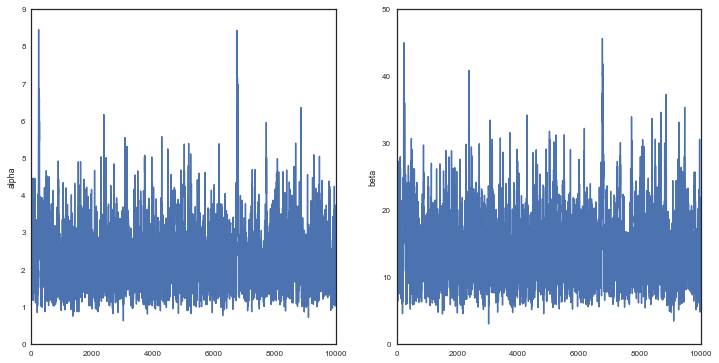

In [22]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(alphatrace)
plt.ylabel('alpha')
plt.subplot(1,2,2)
plt.plot(betatrace)
plt.ylabel('beta')

### Plots of the posterior

We plot the $\alpha$ and $\beta$ marginals and create a 2D histogram or KDE plot (`sns.kdeplot` in seaborn) of the marginal posterior density in the space $x = \alpha/\beta$, $y = log(\alpha + \beta)$. We also look at the marginal of $\theta_1$.

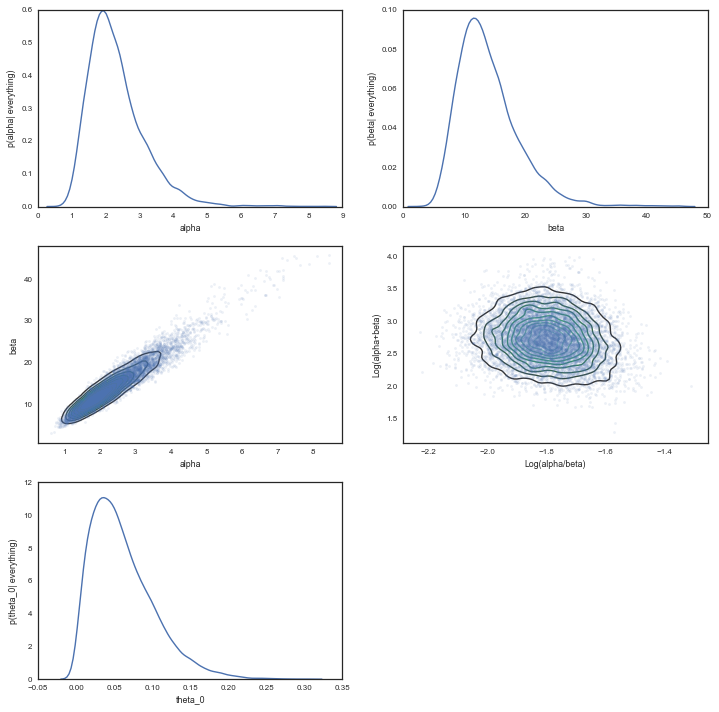

In [23]:
plt.figure(figsize=[12,12])
plt.subplot(3,2,1)
sns.kdeplot(alphatrace)
plt.xlabel('alpha')
plt.ylabel('p(alpha| everything)')
plt.subplot(3,2,2)
sns.kdeplot(betatrace)
plt.xlabel('beta')
plt.ylabel('p(beta| everything)')
plt.subplot(3,2,3)
plt.plot(alphatrace, betatrace,'.', alpha=0.1)
sns.kdeplot(alphatrace, betatrace)
plt.xlabel('alpha')
plt.ylabel('beta')

plt.subplot(3,2,4)
plt.plot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace),'.', alpha=0.1)
sns.kdeplot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace))
plt.xlabel('Log(alpha/beta)')
plt.ylabel('Log(alpha+beta)')

plt.subplot(3,2,5)
sns.kdeplot(thetastrace[:,0])
plt.xlabel('theta_0')
plt.ylabel('p(theta_0| everything)')

### Understanding the posterior

We plot the observed tumor rates on the x-axis against posterior medians for each of the 70 $\theta$'s on the y axis, along with error bars obtained from finding the 2.5 and 97.5 percentiles. 



In [24]:
percentiles=np.percentile(thetastrace, [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

If we would not be so clever Bayesian this would have been our tumor rates:

In [25]:
ratios=tumory.astype(float)/tumorn

Here we compare the two

(-0.1, 0.5)

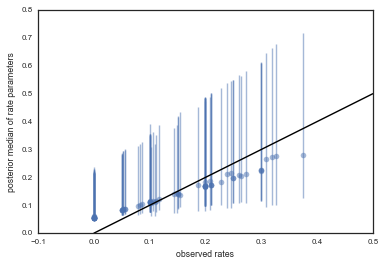

In [26]:
plt.errorbar(ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior median of rate parameters")

plt.xlim(-0.1,0.5)

### The 71st experiment

In a hierarchical model, there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $\tilde{y}$ given a $\theta_i$, and (2) The distribution of observations $\tilde{y}$ drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

We wish to understand what happens for the 'future' $\theta_{71}$.

We finally, compute the posterior prediction for the 71st experiment.

In [27]:
# number of samples we have for alpha and beta
n_pos_samples = alphatrace.shape[0]

# number of samples we want to generate for theta_71 
n_samples_per_param = 100

from scipy.stats import binom

posterior71 = np.empty((n_pos_samples, n_samples_per_param))

for i in xrange(n_samples_per_param):
    # integral Beta(a+y_71, b+n_71 - y_71) * p(a,b, theta | y, n) d theta
    # integral p()
    posterior71[:,i]=beta.rvs(alphatrace+4, betatrace+10)

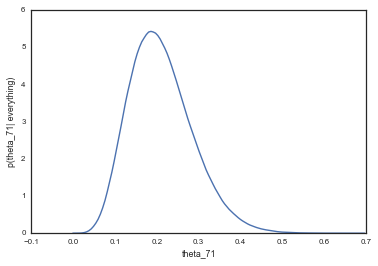

In [28]:
posterior71_flat = posterior71.flatten()
sns.kdeplot(posterior71_flat)
plt.xlabel('theta_71')
plt.ylabel('p(theta_71| everything)')

In [29]:
# numpy function falttens by default
percentiles =np.percentile(posterior71, [2.5,50.0, 97.5])

print "Percentiles: ", percentiles
print "Naive rate: ", 4.0/14

Percentiles:  [ 0.08599607  0.20304554  0.37891892]
Naive rate:  0.285714285714


# For exercise the same model in PYMC

In [30]:
N=70
mu = pm.Uniform("mu",0.00001,1., value=0.13)
nu = pm.Uniform("nu",0.00001,1., value=0.01)
 
@pm.deterministic
def alpha(mu=mu, nu=nu, name='alpha'):
    return mu/(nu*nu)

@pm.deterministic
def beta(mu=mu, nu=nu, name='beta'):
    return (1.-mu)/(nu*nu)


thetas=pm.Container([pm.Beta("theta_%i" % i, alpha, beta) for i in range(N)])
deaths = pm.Binomial('deaths', n=tumorn, p=thetas, value=tumory, size=N, observed=True)

In [31]:
model = pm.Model([mu,nu,alpha, thetas, beta, deaths])
mc = pm.MCMC(model)
mc.sample(iter=30000, burn=20000)

 [-----------------100%-----------------] 30000 of 30000 complete in 130.9 sec

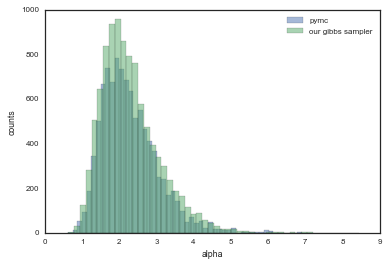

1.70220934901
10.6801912712


In [32]:
bins = 50
plt.hist(alpha.trace(),bins=bins, alpha=0.5, label='pymc')
plt.hist(alphatrace[:len(alpha.trace())], bins=bins, alpha=0.5, label='our gibbs sampler')
plt.xlabel("alpha")
plt.ylabel("counts")
plt.legend()
plt.show()
print alpha.trace()[0]
print beta.trace()[0]

Getting the posterior for the 71st experiment:


In [33]:
p71=np.empty((1000,3000))
combpdf=np.zeros(1000)
xra=np.linspace(0.,1.,1000)
for i in range(3000):
    p71[:,i] = stats.beta.pdf(xra, alphatrace[i]+4, betatrace[i]+10)
for j in range(1000):
    combpdf[j] = combpdf[j] + p71[j,:].sum()
p71.shape, p71[2,:].shape

((1000L, 3000L), (3000L,))

(-0.1, 0.6)

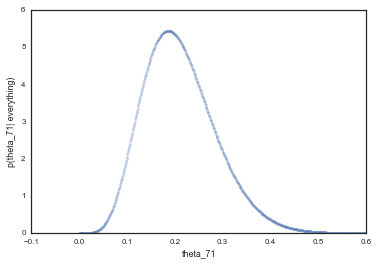

In [34]:
plt.plot(xra, combpdf/3000., '.', alpha=0.3)
plt.xlabel('theta_71')
plt.ylabel('p(theta_71| everything)')
plt.xlim([-.1,.6])

Compare that with the sample estimate

In [35]:
4.0/14

0.2857142857142857